In [13]:
#error message 제거
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [14]:
IMAGE_PATH = '/home/jwjang/final_final_data'

In [15]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import pathlib
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Conv2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras.models import Model,Sequential
from tensorflow.keras.preprocessing import image

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.9.12
Tensorflow version: 2.8.0
Keras version: 2.8.0


In [16]:
IMAGE_SIZE = 224
BATCH_SIZE = 16

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
)

train_generator = datagen.flow_from_directory(
    IMAGE_PATH,
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    subset = 'training'
)

valid_generator = datagen.flow_from_directory(
    IMAGE_PATH,
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    subset = 'validation'
)

Found 26236 images belonging to 8 classes.
Found 6557 images belonging to 8 classes.


In [17]:
image_batch, label_batch = next(valid_generator)
image_batch.shape, label_batch.shape

((16, 224, 224, 3), (16, 8))

In [18]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('can_labels.txt', 'w') as f:
  f.write(labels)

{'2%_peach': 0, 'chilsung_cider': 1, 'coca_cola': 2, 'demisoda': 3, 'fanta_orange': 4, 'pocari_sweat': 5, 'powerade': 6, 'welchs_grape': 7}


In [19]:
#build the Resnet model 
resnet = ResNet50(weights='imagenet',
                      input_shape= (224,224,3),
                      include_top= False)  

In [20]:
# for layer in resnet.layers:
#     layer.trainable = False
    
# # This will let us use the default weights used by the imagenet.    

In [21]:
# # Set the flatten layer.
# x = Flatten() (resnet.output)
# outputs = Dense(8, activation='softmax')(x)
# model = Model(inputs=resnet.input, outputs=outputs)

In [22]:
# let's train our Model 
inputs = resnet.input
# add an average pooling layer
x = resnet.output
x = GlobalAveragePooling2D()(x)
#first dense layer
x = Dense(512, activation='relu')(x)
#dropout 
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

# output layer
outputs = Dense(8, activation ='softmax')(x)
# this is the model we will train
model = Model(inputs=inputs, outputs=outputs)

In [23]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [24]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator), 
                    epochs=55,
                    validation_data=valid_generator,
                    validation_steps=len(valid_generator))

Epoch 1/55
1640/1640 [==============================] - 298s 179ms/step - loss: 0.4820 - accuracy: 0.8678 - val_loss: 123.7952 - val_accuracy: 0.1447
Epoch 2/55
1640/1640 [==============================] - 294s 179ms/step - loss: 0.1585 - accuracy: 0.9534 - val_loss: 0.0419 - val_accuracy: 0.9883
Epoch 3/55
1640/1640 [==============================] - 293s 179ms/step - loss: 0.0706 - accuracy: 0.9797 - val_loss: 0.0332 - val_accuracy: 0.9873
Epoch 4/55
1640/1640 [==============================] - 293s 179ms/step - loss: 0.0674 - accuracy: 0.9817 - val_loss: 0.0760 - val_accuracy: 0.9812
Epoch 5/55
1640/1640 [==============================] - 293s 179ms/step - loss: 0.0568 - accuracy: 0.9840 - val_loss: 0.0522 - val_accuracy: 0.9884
Epoch 6/55
1640/1640 [==============================] - 293s 179ms/step - loss: 0.0456 - accuracy: 0.9881 - val_loss: 0.0832 - val_accuracy: 0.9741
Epoch 7/55
1640/1640 [==============================] - 294s 179ms/step - loss: 0.0387 - accuracy: 0.9897 - va

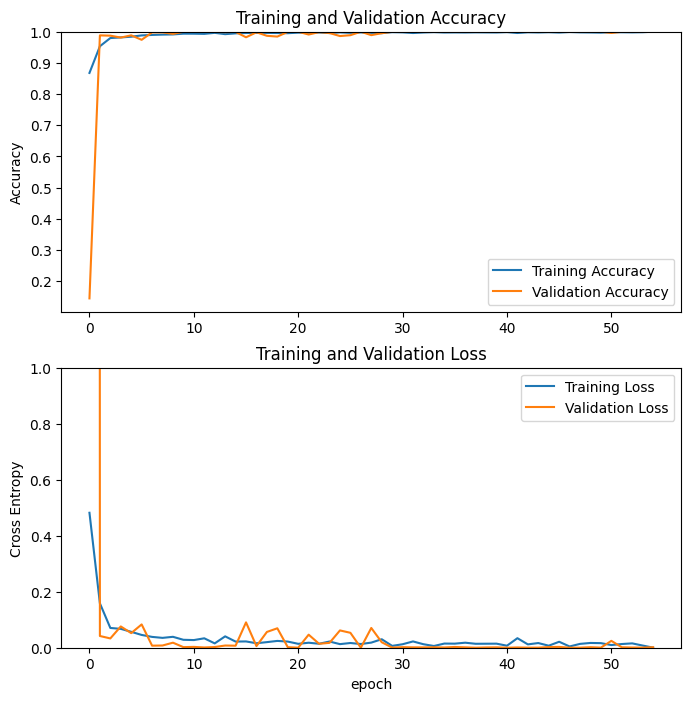

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('resnet50_1108_0200.tflite', 'wb') as f:
  f.write(tflite_model)

2022-11-08 12:45:49.955856: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpdgvt_o6x/assets


2022-11-08 12:46:06.396313: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-11-08 12:46:06.396350: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.


In [27]:
prediction = model.predict(valid_generator)

prediction

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [28]:
prediction = np.argmax(prediction, axis = 1)
prediction

array([1, 7, 2, ..., 2, 2, 2])

In [29]:
unseen_data_path = '/home/jwjang/project_tf28/data/unseen-data/'

img = image.load_img(unseen_data_path + 'fanta_1.jpg', target_size = (IMAGE_SIZE, IMAGE_SIZE))

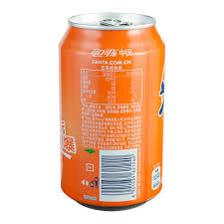

In [30]:
img

In [31]:
x = image.img_to_array(img)
x

array([[[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       ...,

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 2

In [32]:
x.shape

(224, 224, 3)

In [33]:
x = x / 255

In [34]:
x = np.expand_dims(x, axis = 0)
img_data = preprocess_input(x)

In [35]:
x.shape, img_data.shape

((1, 224, 224, 3), (1, 224, 224, 3))

In [36]:
model.predict(img_data)

array([[0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [37]:
a = np.argmax(model.predict(img_data), axis = 1)
a

array([2])

In [38]:
def unseen_data_test(path, image_name, model):
    img = image.load_img(path + image_name, target_size = IMAGE_SIZE)
    print('Original Image')
#     print(img)
    plt.imshow(img)
    x = image.img_to_array(img)
    x = x / 255
    x = np.expand_dims(x, axis = 0)
    img_data = preprocess_input(x)
    a = np.argmax(model.predict(img_data), axis = 1)
    print(a)

In [39]:
unseen_data_test(unseen_data_path, 'welches_1.jpg', model)

TypeError: 'int' object is not subscriptable